## Init

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import brier_score_loss

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform, loguniform, beta
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import optuna
from optuna.trial import TrialState

import warnings
warnings.filterwarnings("ignore")

/home/JanTar/miniconda3/envs/automl1/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Datasets

In [2]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv").squeeze()
X2 = pd.read_csv("preprocessed_datasets/gym_data.csv")
y2 = pd.read_csv("preprocessed_datasets/gym_target.csv").squeeze()
X3 = pd.read_csv("preprocessed_datasets/heartDisease_data.csv")
y3 = pd.read_csv("preprocessed_datasets/heartDisease_target.csv").squeeze()
X4 = pd.read_csv("preprocessed_datasets/titanic_data.csv")
y4 = pd.read_csv("preprocessed_datasets/titanic_target.csv").squeeze()

In [3]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)

In [4]:
datasets = [
    (X1_train, X1_test, y1_train, y1_test, "Bank"),
    (X2_train, X2_test, y2_train, y2_test, "Gym"),
    (X3_train, X3_test, y3_train, y3_test, "Heart Disease"),
    (X4_train, X4_test, y4_train, y4_test, "Titanic")
]
baseline_brier_scores = []


model = RandomForestClassifier(random_state=42)

for X_train, X_test, y_train, y_test, _ in tqdm(datasets, desc="Processing datasets"):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)
    baseline_brier_scores.append(brier)

for i, (brier, (_, _, _, _, dataset_name)) in enumerate(zip(baseline_brier_scores, datasets), 1):
    print(f"Dataset {i} ({dataset_name}): Baseline Brier score = {brier:.4f}")

Processing datasets: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

Dataset 1 (Bank): Baseline Brier score = 0.1892
Dataset 2 (Gym): Baseline Brier score = 0.1819
Dataset 3 (Heart Disease): Baseline Brier score = 0.1067
Dataset 4 (Titanic): Baseline Brier score = 0.1520


### Constansts and functions

In [5]:
N_ITER = 100
RANDOM_STATE = 42
SCORER = 'neg_brier_score'  # maximize negative value because in standard brier score the lower, the better
WINDOW_SIZE = 10
ABS_TOL = 0.001 
CV = 5

N_JOBS = -1




def chart_random(stabilized_at, brier_per_iter, iters, best_so_far, dataset_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(iters, brier_per_iter, s=12, alpha=0.6, label='Brier per iteration')
    plt.plot(iters, best_so_far, linewidth=2, label='Best so far')
    if stabilized_at is not None:
        plt.axvline(stabilized_at, linestyle='--', linewidth=1, label=f'Stabilized at {stabilized_at}')
    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title(f'Brier per Random Search iteration and best-so-far for {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    

def detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len = WINDOW_SIZE):
    """
    Szuka pierwszego okna długości 10 takie, że wszystkie 9 kolejnych różnic
    między elementami okna mają wartość absolutną < abs_tol.
    Zwraca (stabilized_at_1based, stabilized_value) lub (None, None).
    """
    arr = np.asarray(best_so_far)
    n = arr.shape[0]
    if n < window_len:
        return None, None

    for start in range(0, n - window_len + 1):
        window = arr[start:start + window_len]
        diffs = np.abs(np.diff(window)) 
        if np.all(diffs < abs_tol):
            return start + 1, float(window[0])
    return None, None

## Random Search CV

In [6]:
param_distributions = {
      'n_estimators': randint(100, 1500), # 100-999
      'criterion': ['log_loss', 'entropy', 'gini'], 
      'max_depth': [10, 15, 20, None],  # Limit tree depth
      'min_samples_split': randint(2, 20),
      'min_samples_leaf': randint(1, 10),       # Prevent tiny leaves
      'max_features': ['sqrt', 0.1, 0.33],    # Force feature subsampling
      'max_samples': [0.5, 0.7, 0.9, None]
  }





model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=N_ITER,
    scoring=SCORER,
    cv=CV,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    refit=True ###
)

tuned_brier_scores = []
best_params_list = []
cv_results_list = []

Tuning datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


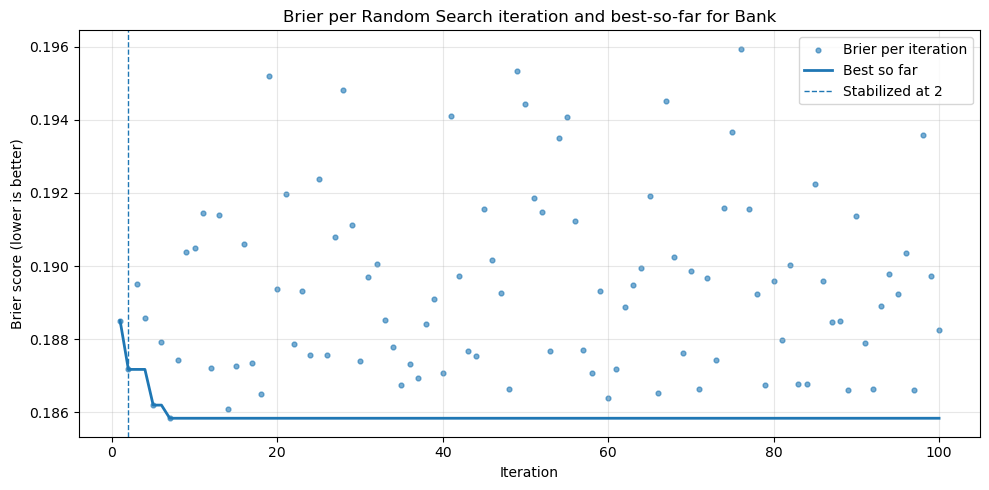

Tuning datasets:  25%|██▌       | 1/4 [15:46<47:19, 946.37s/it]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


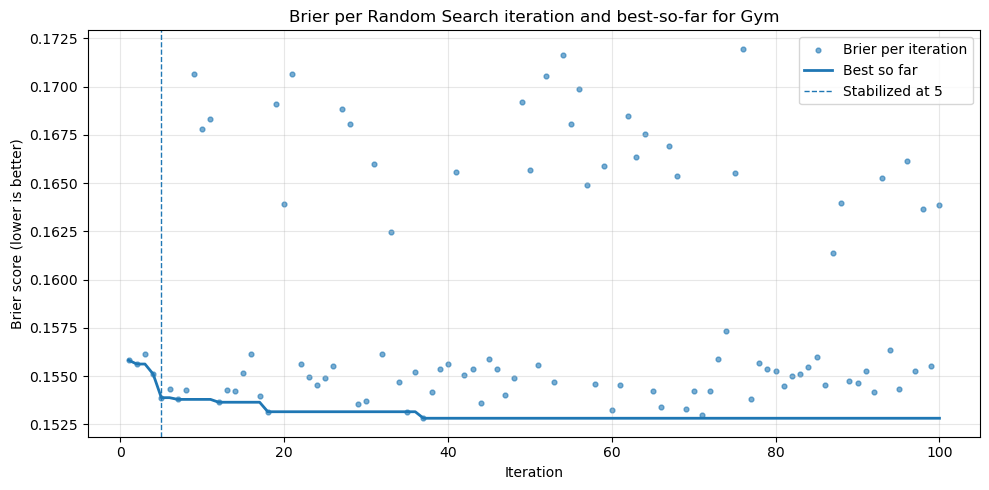

Tuning datasets:  50%|█████     | 2/4 [21:26<19:39, 589.58s/it]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


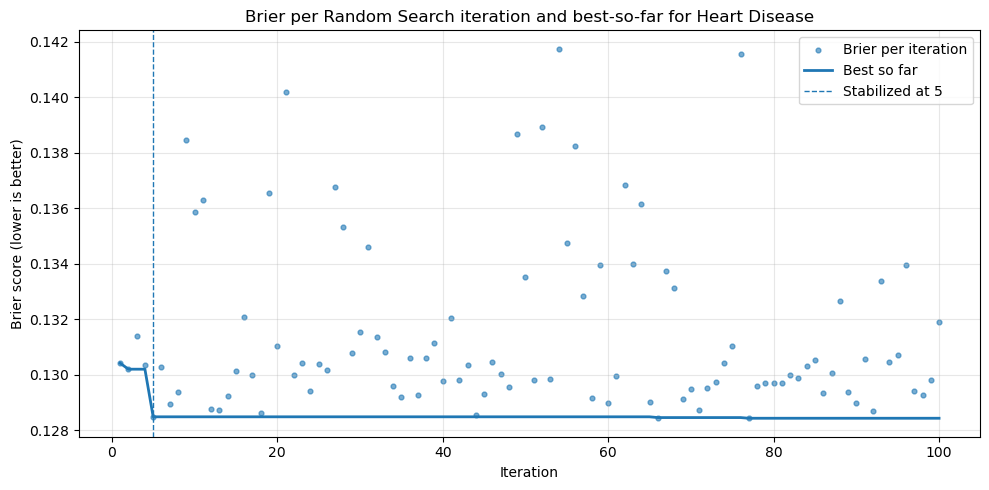

Tuning datasets:  75%|███████▌  | 3/4 [25:13<07:04, 424.33s/it]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


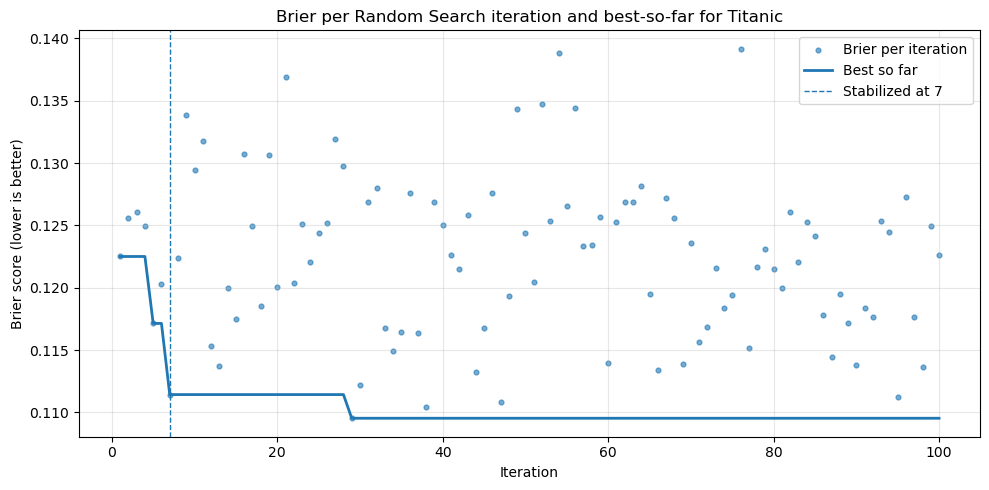

Tuning datasets: 100%|██████████| 4/4 [28:54<00:00, 433.67s/it]


In [7]:
for X_train, X_test, y_train, y_test, dataset_name in tqdm(datasets, desc="Tuning datasets"):
    # Fit the RandomizedSearchCV (or other search object) on training fold
    random_search.fit(X_train, y_train)

    model = random_search.best_estimator_
    
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)

    cv_results = random_search.cv_results_
    best_params = random_search.best_params_.copy()  # dict

    tuned_brier_scores.append(brier)
    best_params_list.append(best_params)
    cv_results_list.append(cv_results)

    
    mean_test_score = -cv_results['mean_test_score']  # Negate if using neg_log_loss
    best_so_far = np.minimum.accumulate(mean_test_score)

    # detect stabilization (1-based iteration returned)
    stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len=WINDOW_SIZE)
    # Prepare data for plotting
    iters = np.arange(1, len(mean_test_score) + 1)

    # Plot the results for this dataset
    chart_random(stabilized_at, mean_test_score, iters, best_so_far, dataset_name)

### Random Search Results

In [8]:
# Combine all cv_results into one DataFrame
all_results = []
for i, cv_res in enumerate(cv_results_list):
    df = pd.DataFrame(cv_res)
    dataset_name = datasets[i][4]  # adjust if your dataset tuple differs
    df["dataset"] = dataset_name
    df["brier_score"] = tuned_brier_scores[i]
    all_results.append(df)

# Merge into one full DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

# Keep the most informative columns
cols_to_keep = [
    "dataset",
    "params",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
    "mean_fit_time",
    "mean_score_time",
    "brier_score"
]
existing_cols = [c for c in cols_to_keep if c in all_results_df.columns]
results_to_save = all_results_df[existing_cols]

# Save all model evaluations
results_to_save.to_csv("RandomForestData/all_randomsearch_results.csv", index=False)
print(f"✅ Saved {len(all_results_df)} rows to RandomForestData/all_randomsearch_results.csv")

# Extract best model per dataset
best_rows = all_results_df.loc[all_results_df.groupby("dataset")["rank_test_score"].idxmin()]
best_rows = best_rows.sort_values("dataset").reset_index(drop=True)
best_rows.to_csv("RandomForestData/best_models_summary.csv", index=False)
print(f"✅ Saved {len(best_rows)} best model summaries to RandomForestData/best_models_summary.csv")

# Plot convergence charts
# for i, cv_res in enumerate(cv_results_list):
#     dataset_name = datasets[i][4]
#     cv_results = cv_res
#     mean_test_score = -np.array(cv_results["mean_test_score"])  # negate if using neg metric
#     iters = np.arange(1, len(mean_test_score) + 1)
#     best_so_far = np.minimum.accumulate(mean_test_score)

#     stabilized_at, stabilized_value = detect_stabilization_by_last(
#         best_so_far,
#         abs_tol=ABS_TOL,
#         window_len=WINDOW_SIZE
#     )

#     chart_random(stabilized_at, mean_test_score, iters, best_so_far, dataset_name)

# plt.tight_layout()
# plt.show()


✅ Saved 400 rows to RandomForestData/all_randomsearch_results.csv
✅ Saved 4 best model summaries to RandomForestData/best_models_summary.csv


In [9]:
pd.set_option('display.max_colwidth', 300)


# Ensure we work with a copy
df = pd.read_csv("RandomForestData/all_randomsearch_results.csv")
#df = all_results_df.copy()
# Sort within each dataset by brier_score ascending (lower is better)
df_sorted = df.sort_values(by=["dataset", "mean_test_score"], ascending=[True, False])

# Get top 10 per dataset
top10_per_dataset = df_sorted.groupby("dataset").head(10).reset_index(drop=True)

# Show in console
for dataset_name, subset in top10_per_dataset.groupby("dataset"):
    print(f"\nTop 10 models for dataset: {dataset_name}")
    display(subset[["dataset", "rank_test_score", "mean_test_score", "params"]])



Top 10 models for dataset: Bank


,dataset,rank_test_score,mean_test_score,params
0,Bank,1,-0.185842,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1469}"
1,Bank,2,-0.186105,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 491}"
2,Bank,3,-0.186201,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.33, 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 1367}"
3,Bank,4,-0.186386,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.9, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 976}"
4,Bank,5,-0.186498,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.33, 'max_samples': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 742}"
5,Bank,6,-0.186538,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1209}"
6,Bank,7,-0.186612,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 19, 'n_estimators': 146}"
7,Bank,8,-0.186613,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 18, 'n_estimators': 610}"
8,Bank,9,-0.186630,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 116}"
9,Bank,10,-0.186644,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.33, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 1115}"



Top 10 models for dataset: Gym


,dataset,rank_test_score,mean_test_score,params
10,Gym,1,-0.152819,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.33, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 243}"
11,Gym,2,-0.152964,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.33, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 1115}"
12,Gym,3,-0.153157,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.33, 'max_samples': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 742}"
13,Gym,4,-0.153157,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.33, 'max_samples': 0.9, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 588}"
14,Gym,5,-0.153260,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.9, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 976}"
15,Gym,6,-0.153305,"{'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': 0.9, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1377}"
16,Gym,7,-0.153407,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1209}"
17,Gym,8,-0.153566,"{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 741}"
18,Gym,9,-0.153586,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 1258}"
19,Gym,10,-0.153649,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 1176}"



Top 10 models for dataset: Heart Disease


,dataset,rank_test_score,mean_test_score,params
20,Heart Disease,1,-0.128428,"{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1019}"
21,Heart Disease,2,-0.128453,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1209}"
22,Heart Disease,3,-0.128480,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.33, 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 1367}"
23,Heart Disease,4,-0.128544,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 1258}"
24,Heart Disease,5,-0.128607,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.33, 'max_samples': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 742}"
25,Heart Disease,6,-0.128701,"{'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.33, 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 14, 'n_estimators': 752}"
26,Heart Disease,7,-0.128722,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 620}"
27,Heart Disease,8,-0.128739,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.33, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 1115}"
28,Heart Disease,9,-0.128774,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 1176}"
29,Heart Disease,10,-0.128930,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1469}"



Top 10 models for dataset: Titanic


,dataset,rank_test_score,mean_test_score,params
30,Titanic,1,-0.109538,"{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 741}"
31,Titanic,2,-0.110454,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 996}"
32,Titanic,3,-0.110842,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1119}"
33,Titanic,4,-0.111235,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1033}"
34,Titanic,5,-0.111435,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1469}"
35,Titanic,6,-0.112210,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1253}"
36,Titanic,7,-0.113234,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 1258}"
37,Titanic,8,-0.113412,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1209}"
38,Titanic,9,-0.113665,"{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 0.1, 'max_samples': 0.9, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 755}"
39,Titanic,10,-0.113746,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 620}"


### Results short

In [10]:
for i, (brier, baseline_brier, params, (_, _, _, _, dataset_name)) in enumerate(zip(tuned_brier_scores, baseline_brier_scores, best_params_list, datasets), 1):
    print(f"""
    Dataset {i} ({dataset_name}): 
        Tuned Brier score = {brier:.4f}, Baseline Brier score = {baseline_brier:.4f} \n
    Best parameters:
        n_estimators: {params['n_estimators']:.4f}
        criterion: {params['criterion']}
        max_depth:{params['max_depth']}
        min_samples_split:{params['min_samples_split']}
        min_samples_leaf:{params['min_samples_leaf']}
        max_features:{params['max_features']}
    """)


    Dataset 1 (Bank): 
        Tuned Brier score = 0.1847, Baseline Brier score = 0.1892 

    Best parameters:
        n_estimators: 1469.0000
        criterion: entropy
        max_depth:None
        min_samples_split:10
        min_samples_leaf:2
        max_features:sqrt
    

    Dataset 2 (Gym): 
        Tuned Brier score = 0.1770, Baseline Brier score = 0.1819 

    Best parameters:
        n_estimators: 243.0000
        criterion: entropy
        max_depth:20
        min_samples_split:8
        min_samples_leaf:3
        max_features:0.33
    

    Dataset 3 (Heart Disease): 
        Tuned Brier score = 0.1081, Baseline Brier score = 0.1067 

    Best parameters:
        n_estimators: 1019.0000
        criterion: log_loss
        max_depth:10
        min_samples_split:10
        min_samples_leaf:5
        max_features:sqrt
    

    Dataset 4 (Titanic): 
        Tuned Brier score = 0.1498, Baseline Brier score = 0.1520 

    Best parameters:
        n_estimators: 741.0000
    

## Bayesian Optimization

In [11]:
def bayes_optimize(X_loc, y_arr, n_trials=N_ITER, cv=CV, random_state=RANDOM_STATE, n_jobs_model=1, pruner_n_startup_trials=10, verbose=True):
    y_arr = np.asarray(y_arr).ravel()
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    sampler = optuna.samplers.TPESampler(seed=random_state)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=pruner_n_startup_trials, n_warmup_steps=0, interval_steps=1)
    
    # Suppress optuna logging
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

    # Track best score for console output
    best_score = -np.inf #####
    
    def objective(trial):
        nonlocal best_score         #####
        
        # Match the exact parameter distributions from random search
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1499),
            'criterion': trial.suggest_categorical('criterion', ['log_loss', 'entropy', 'gini']),
            'max_depth': trial.suggest_categorical('max_depth', [10, 15, 20, None]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 19),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 9),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 0.1, 0.33]),
            'max_samples': trial.suggest_categorical('max_samples', [0.5, 0.7, 0.9, None])
        }

    #   'n_estimators': randint(100, 1500), # 100-999
    #   'criterion': ['log_loss', 'entropy', 'gini'], 
    #   'max_depth': [10, 15, 20, None],  # Limit tree depth
    #   'min_samples_split': randint(2, 20),
    #   'min_samples_leaf': randint(1, 10),       # Prevent tiny leaves
    #   'max_features': ['sqrt', 0.1, 0.33],    # Force feature subsampling
    #   'max_samples': [0.5, 0.7, 0.9, None]




        model = RandomForestClassifier(**params, random_state=random_state, n_jobs=n_jobs_model)

        neg_briers = []

        for fold_idx, (train_idx, val_idx) in enumerate(cv_splitter.split(X_loc, y_arr)):
            X_tr = X_loc.iloc[train_idx] #if hasattr(X_loc, 'iloc') else X_loc[train_idx]
            X_val = X_loc.iloc[val_idx] #if hasattr(X_loc, 'iloc') else X_loc[val_idx]
            y_tr = y_arr[train_idx]
            y_val = y_arr[val_idx]

            model.fit(X_tr, y_tr)

            probs = model.predict_proba(X_val)[:, 1]
            neg_brier = -brier_score_loss(y_val, probs)
            neg_briers.append(neg_brier)

            mean_neg_so_far = float(np.mean(neg_briers))
            trial.report(mean_neg_so_far, step=fold_idx)
            if trial.should_prune():
                raise optuna.TrialPruned()
            
        mean_neg = float(np.mean(neg_briers))
        


        # Print only when new best is found
        if verbose and mean_neg > best_score:
            best_score = mean_neg
            brier_score = -mean_neg
            params_str = f"n_est={params['n_estimators']}, crit={params['criterion']}, depth={params['max_depth']}, " \
                        f"split={params['min_samples_split']}, leaf={params['min_samples_leaf']}, feat={params['max_features']}"
            print(f"  Trial {trial.number:3d}: Brier={brier_score:.4f} | {params_str}")
        


        return mean_neg
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False) #####

    trials = study.trials
    neg_scores = [t.value if t.value is not None else np.nan for t in trials]
    brier_per_iter = -np.array(neg_scores, dtype=float)

    best_so_far = []
    current_best = np.inf
    for v in brier_per_iter:
        if np.isnan(v):
            best_so_far.append(current_best if current_best != np.inf else np.nan)
        else:
            if v < current_best:
                current_best = v
            best_so_far.append(current_best)
    best_so_far = np.array(best_so_far, dtype=float)

    completed = [t for t in trials if t.state == TrialState.COMPLETE and t.value is not None]
    best_trial = max(completed, key=lambda tr: tr.value)
    best_params = best_trial.params
    best_brier = float(best_trial.value)

    return {
        'brier_per_iter': brier_per_iter,
        'best_so_far': best_so_far,
        'best_params': best_params,
        'best_brier': best_brier,
        'study': study  # Return study object for trial data extraction
    }

In [12]:
bayes_brier_scores = []
bayes_best_params_list = []
bayes_results_list = []

Bayesian Tuning:   0%|          | 0/4 [00:00<?, ?it/s]


Optimizing Bank dataset...
  Trial   0: Brier=0.1897 | n_est=624, crit=log_loss, depth=None, split=12, leaf=7, feat=0.1
  Trial   1: Brier=0.1871 | n_est=834, crit=gini, depth=None, split=16, leaf=2, feat=0.1
  Trial   4: Brier=0.1868 | n_est=204, crit=log_loss, depth=15, split=15, leaf=1, feat=0.33
  Trial   6: Brier=0.1867 | n_est=540, crit=entropy, depth=15, split=7, leaf=2, feat=sqrt
  Trial   7: Brier=0.1852 | n_est=855, crit=entropy, depth=None, split=17, leaf=1, feat=sqrt
  Trial  65: Brier=0.1851 | n_est=1491, crit=entropy, depth=None, split=19, leaf=1, feat=sqrt


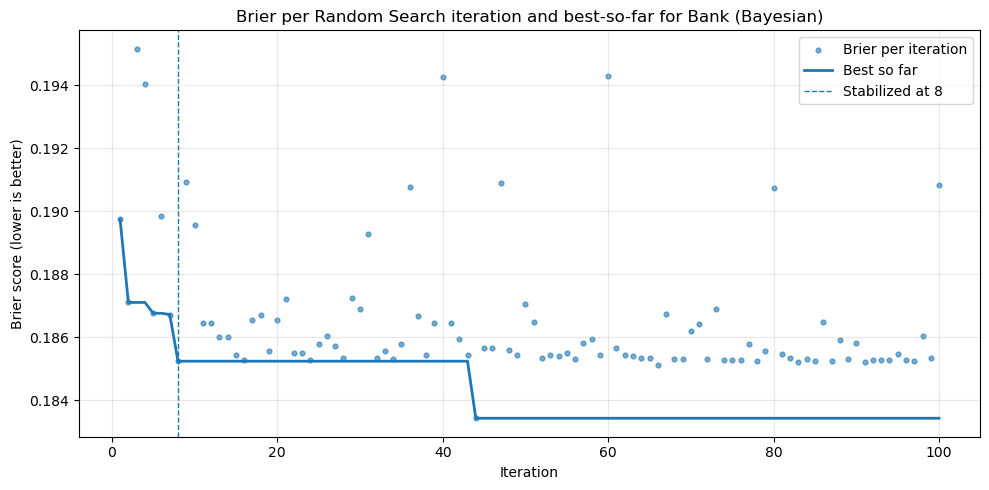

Bayesian Tuning:  25%|██▌       | 1/4 [19:01<57:04, 1141.42s/it]


✓ Final test Brier: 0.1839
✓ Stabilized at iteration: 8

Optimizing Gym dataset...
  Trial   0: Brier=0.1676 | n_est=624, crit=log_loss, depth=None, split=12, leaf=7, feat=0.1
  Trial   1: Brier=0.1661 | n_est=834, crit=gini, depth=None, split=16, leaf=2, feat=0.1
  Trial   3: Brier=0.1652 | n_est=1185, crit=log_loss, depth=10, split=7, leaf=4, feat=0.1
  Trial   4: Brier=0.1563 | n_est=204, crit=log_loss, depth=15, split=15, leaf=1, feat=0.33
  Trial   6: Brier=0.1552 | n_est=540, crit=entropy, depth=15, split=7, leaf=2, feat=sqrt
  Trial   9: Brier=0.1550 | n_est=785, crit=log_loss, depth=10, split=13, leaf=6, feat=0.33
  Trial  16: Brier=0.1547 | n_est=324, crit=entropy, depth=10, split=13, leaf=4, feat=0.33
  Trial  54: Brier=0.1547 | n_est=1079, crit=entropy, depth=15, split=3, leaf=4, feat=sqrt
  Trial  56: Brier=0.1547 | n_est=1254, crit=entropy, depth=15, split=3, leaf=4, feat=sqrt
  Trial  58: Brier=0.1547 | n_est=1495, crit=entropy, depth=15, split=3, leaf=4, feat=sqrt
  Tri

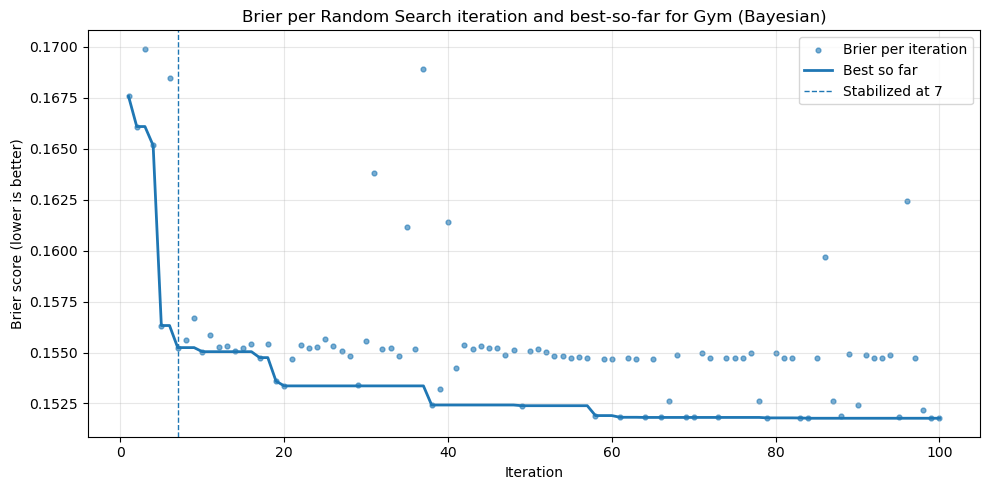

Bayesian Tuning:  50%|█████     | 2/4 [30:18<28:56, 868.31s/it] 


✓ Final test Brier: 0.1785
✓ Stabilized at iteration: 7

Optimizing Heart Disease dataset...
  Trial   0: Brier=0.1348 | n_est=624, crit=log_loss, depth=None, split=12, leaf=7, feat=0.1
  Trial   1: Brier=0.1323 | n_est=834, crit=gini, depth=None, split=16, leaf=2, feat=0.1
  Trial   3: Brier=0.1309 | n_est=1185, crit=log_loss, depth=10, split=7, leaf=4, feat=0.1
  Trial   4: Brier=0.1297 | n_est=204, crit=log_loss, depth=15, split=15, leaf=1, feat=0.33
  Trial   6: Brier=0.1268 | n_est=540, crit=entropy, depth=15, split=7, leaf=2, feat=sqrt
  Trial  11: Brier=0.1268 | n_est=406, crit=entropy, depth=20, split=7, leaf=3, feat=sqrt
  Trial  14: Brier=0.1267 | n_est=389, crit=entropy, depth=20, split=5, leaf=3, feat=sqrt
  Trial  19: Brier=0.1266 | n_est=434, crit=entropy, depth=20, split=5, leaf=2, feat=sqrt
  Trial  61: Brier=0.1265 | n_est=1403, crit=entropy, depth=None, split=11, leaf=1, feat=sqrt
  Trial  62: Brier=0.1263 | n_est=1412, crit=entropy, depth=None, split=11, leaf=2, fea

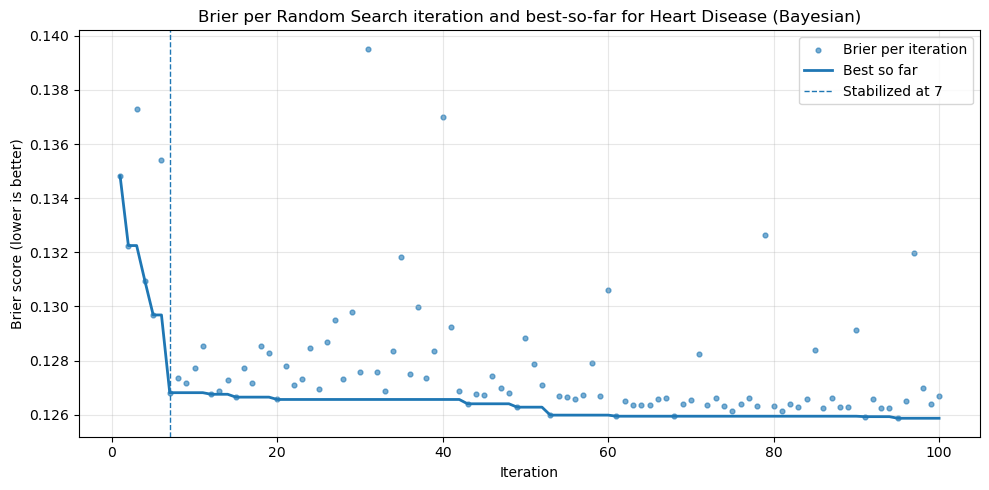

Bayesian Tuning:  75%|███████▌  | 3/4 [41:26<12:56, 776.88s/it]


✓ Final test Brier: 0.1065
✓ Stabilized at iteration: 7

Optimizing Titanic dataset...
  Trial   0: Brier=0.1296 | n_est=624, crit=log_loss, depth=None, split=12, leaf=7, feat=0.1
  Trial   1: Brier=0.1235 | n_est=834, crit=gini, depth=None, split=16, leaf=2, feat=0.1
  Trial   3: Brier=0.1231 | n_est=1185, crit=log_loss, depth=10, split=7, leaf=4, feat=0.1
  Trial   4: Brier=0.1214 | n_est=204, crit=log_loss, depth=15, split=15, leaf=1, feat=0.33
  Trial   6: Brier=0.1156 | n_est=540, crit=entropy, depth=15, split=7, leaf=2, feat=sqrt
  Trial  14: Brier=0.1154 | n_est=1070, crit=gini, depth=10, split=5, leaf=1, feat=sqrt
  Trial  19: Brier=0.1147 | n_est=1224, crit=entropy, depth=10, split=5, leaf=2, feat=sqrt
  Trial  38: Brier=0.1143 | n_est=1170, crit=log_loss, depth=10, split=6, leaf=1, feat=sqrt
  Trial  53: Brier=0.1141 | n_est=1353, crit=log_loss, depth=10, split=7, leaf=1, feat=sqrt
  Trial  83: Brier=0.1141 | n_est=1377, crit=log_loss, depth=10, split=7, leaf=1, feat=sqrt


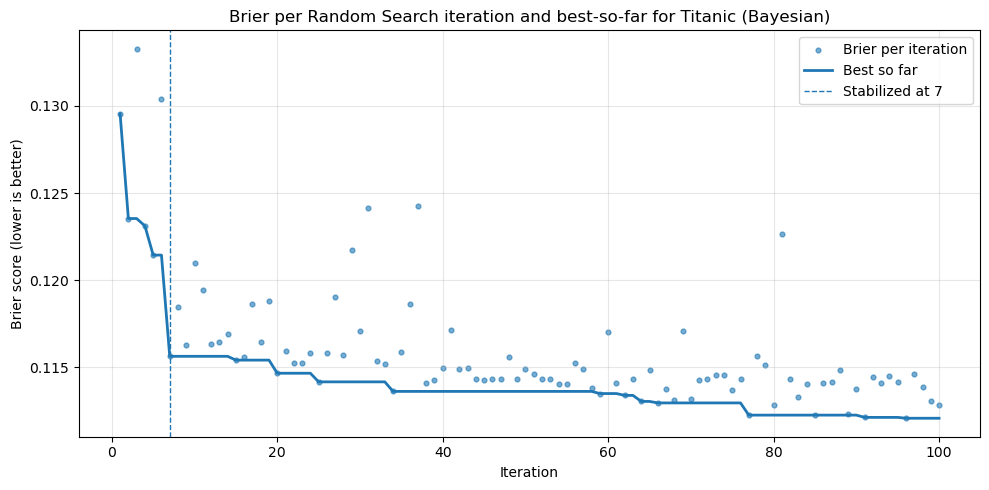

Bayesian Tuning: 100%|██████████| 4/4 [52:44<00:00, 791.16s/it]


✓ Final test Brier: 0.1510
✓ Stabilized at iteration: 7

Saved all Bayesian trials to RandomForestData/all_bayesian_results.csv
Saved individual dataset trials to RandomForestData/bayesian_trials_[dataset].csv


In [13]:
all_bayesian_trials = [] #####

for X_train, X_test, y_train, y_test, dataset_name in tqdm(datasets, desc="Bayesian Tuning"):
    print(f"\n{'='*60}")
    print(f"Optimizing {dataset_name} dataset...")
    print(f"{'='*60}")
    
    # Run Bayesian optimization
    result = bayes_optimize(X_train, y_train, n_trials=N_ITER, n_jobs_model=-1, verbose=True)
    
    # Extract best parameters
    best_params = result['best_params']
    bayes_best_params_list.append(best_params)
    bayes_results_list.append(result)
    
    # Train final model with best parameters and evaluate on test set
    model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)
    bayes_brier_scores.append(brier)
    
    # Extract all trials from study
    study = result['study']
    trials_data = []
    for trial in study.trials:
        trial_dict = {
            'trial_number': trial.number,
            'state': str(trial.state),
            'value': trial.value if trial.value is not None else np.nan,
            'brier_score': -trial.value if trial.value is not None else np.nan,
            'duration': trial.duration.total_seconds() if trial.duration else np.nan,
            'params': str(trial.params),
            **trial.params  # Unpack parameters as separate columns
        }
        trials_data.append(trial_dict)
    
    # Create DataFrame for this dataset
    trials_df = pd.DataFrame(trials_data)
    trials_df['dataset'] = dataset_name
    trials_df['test_brier_score'] = brier
    
    # Save individual dataset trials
    trials_df.to_csv(f'RandomForestData/bayesian_trials_{dataset_name.replace(" ", "_")}.csv', index=False)
    all_bayesian_trials.append(trials_df)
    
    # Visualization
    brier_per_iter = result['brier_per_iter']
    best_so_far = result['best_so_far']
    
    # Detect stabilization
    stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len=WINDOW_SIZE)
    
    # Plot
    iters = np.arange(1, len(brier_per_iter) + 1)
    chart_random(stabilized_at, brier_per_iter, iters, best_so_far, f"{dataset_name} (Bayesian)")
    
    # Final summary
    print(f"\n✓ Final test Brier: {brier:.4f}")
    if stabilized_at:
        print(f"✓ Stabilized at iteration: {stabilized_at}")

# Combine all trials
all_bayesian_df = pd.concat(all_bayesian_trials, ignore_index=True)
all_bayesian_df.to_csv('RandomForestData/all_bayesian_results.csv', index=False)

print(f"\n{'='*60}")
print(f"Saved all Bayesian trials to RandomForestData/all_bayesian_results.csv")
print(f"Saved individual dataset trials to RandomForestData/bayesian_trials_[dataset].csv")
print(f"{'='*60}")

### Comparison: Random Search vs Bayesian Optimization

In [14]:
comparison_df = pd.DataFrame({
    'Dataset': [datasets[i][4] for i in range(4)],
    'Baseline': baseline_brier_scores,
    'Random Search': tuned_brier_scores,
    'Bayesian Opt': bayes_brier_scores
})

comparison_df['RS Improvement'] = ((comparison_df['Baseline'] - comparison_df['Random Search']) / comparison_df['Baseline'] * 100).round(2)
comparison_df['Bayes Improvement'] = ((comparison_df['Baseline'] - comparison_df['Bayesian Opt']) / comparison_df['Baseline'] * 100).round(2)
comparison_df['Bayes vs RS'] = ((comparison_df['Random Search'] - comparison_df['Bayesian Opt']) / comparison_df['Random Search'] * 100).round(2)

print("="*60)
print("Brier Score Comparison")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)
print("\nLower Brier scores are better")
print("Improvement % = (Baseline - Method) / Baseline * 100")

Brier Score Comparison
      Dataset  Baseline  Random Search  Bayesian Opt  RS Improvement  Bayes Improvement  Bayes vs RS
         Bank  0.189193       0.184716      0.183886            2.37               2.80         0.45
          Gym  0.181900       0.176995      0.178530            2.70               1.85        -0.87
Heart Disease  0.106674       0.108104      0.106520           -1.34               0.14         1.46
      Titanic  0.152039       0.149756      0.151021            1.50               0.67        -0.84

Lower Brier scores are better
Improvement % = (Baseline - Method) / Baseline * 100


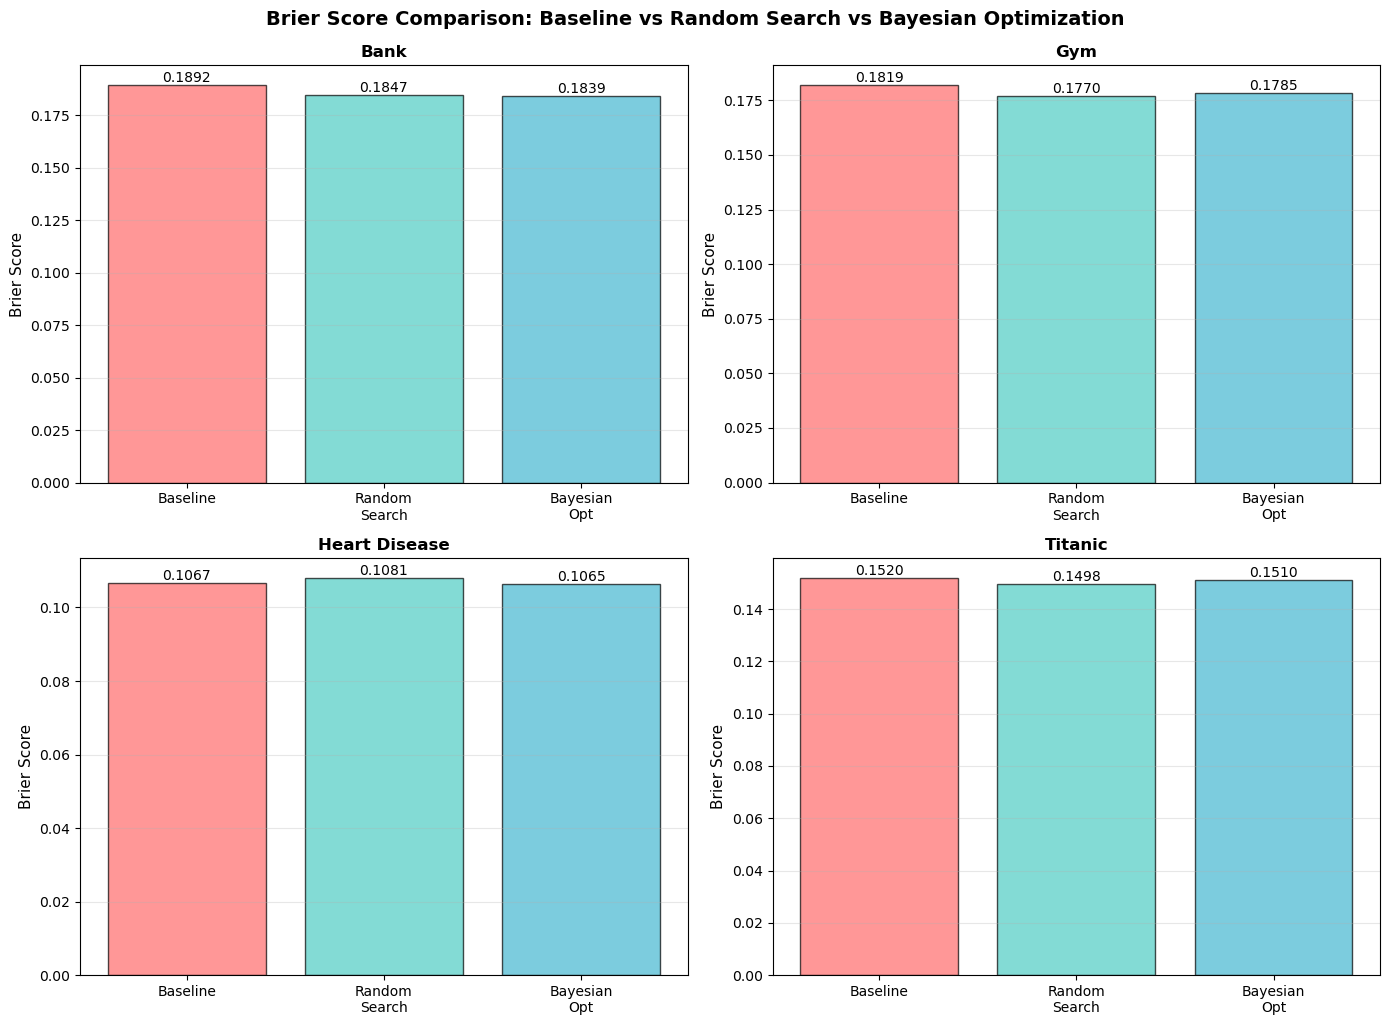

In [15]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (dataset_name, ax) in enumerate(zip([d[4] for d in datasets], axes)):
    methods = ['Baseline', 'Random\nSearch', 'Bayesian\nOpt']
    scores = [baseline_brier_scores[i], tuned_brier_scores[i], bayes_brier_scores[i]]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    
    bars = ax.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Brier Score', fontsize=11)
    ax.set_title(f'{dataset_name}', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle('Brier Score Comparison: Baseline vs Random Search vs Bayesian Optimization', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

### Detailed Results Comparison

In [16]:
for i, (_, _, _, _, dataset_name) in enumerate(datasets):
    print(f"\n{'='*60}")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*60}")
    
    print(f"\nBrier Scores:")
    print(f"  Baseline:       {baseline_brier_scores[i]:.4f}")
    print(f"  Random Search:  {tuned_brier_scores[i]:.4f} (improvement: {comparison_df.loc[i, 'RS Improvement']:.2f}%)")
    print(f"  Bayesian Opt:   {bayes_brier_scores[i]:.4f} (improvement: {comparison_df.loc[i, 'Bayes Improvement']:.2f}%)")
    
    print(f"\nBest Parameters - Random Search:")
    for key, value in best_params_list[i].items():
        print(f"  {key}: {value}")
    
    print(f"\nBest Parameters - Bayesian Optimization:")
    for key, value in bayes_best_params_list[i].items():
        print(f"  {key}: {value}")


Dataset: Bank

Brier Scores:
  Baseline:       0.1892
  Random Search:  0.1847 (improvement: 2.37%)
  Bayesian Opt:   0.1839 (improvement: 2.80%)

Best Parameters - Random Search:
  criterion: entropy
  max_depth: None
  max_features: sqrt
  max_samples: None
  min_samples_leaf: 2
  min_samples_split: 10
  n_estimators: 1469

Best Parameters - Bayesian Optimization:
  n_estimators: 1491
  criterion: entropy
  max_depth: None
  min_samples_split: 19
  min_samples_leaf: 1
  max_features: sqrt
  max_samples: 0.9

Dataset: Gym

Brier Scores:
  Baseline:       0.1819
  Random Search:  0.1770 (improvement: 2.70%)
  Bayesian Opt:   0.1785 (improvement: 1.85%)

Best Parameters - Random Search:
  criterion: entropy
  max_depth: 20
  max_features: 0.33
  max_samples: 0.7
  min_samples_leaf: 3
  min_samples_split: 8
  n_estimators: 243

Best Parameters - Bayesian Optimization:
  n_estimators: 1476
  criterion: entropy
  max_depth: 15
  min_samples_split: 3
  min_samples_leaf: 4
  max_features: s

## Load Results from Files

If you've already run the optimizations and want to load the results from saved files:

In [17]:
# Load Random Search results
rs_results_df = pd.read_csv('RandomForestData/all_randomsearch_results.csv')
rs_best_models = pd.read_csv('RandomForestData/best_models_summary.csv')

# Load Bayesian Optimization results
bayes_results_df = pd.read_csv('RandomForestData/all_bayesian_results.csv')

print(f"Loaded Random Search: {len(rs_results_df)} trials")
print(f"Loaded Bayesian Optimization: {len(bayes_results_df)} trials")

Loaded Random Search: 400 trials
Loaded Bayesian Optimization: 400 trials


In [18]:
# Reconstruct the variables needed for comparison from loaded data
dataset_names = ['Bank', 'Gym', 'Heart Disease', 'Titanic']

# Extract test brier scores from loaded data
tuned_brier_scores_loaded = []
bayes_brier_scores_loaded = []

for ds_name in dataset_names:
    # Random Search - get test brier score from best model
    rs_best = rs_best_models[rs_best_models['dataset'] == ds_name]['brier_score'].values[0]
    tuned_brier_scores_loaded.append(rs_best)
    
    # Bayesian - get test brier score (unique per dataset)
    bayes_test = bayes_results_df[bayes_results_df['dataset'] == ds_name]['test_brier_score'].values[0]
    bayes_brier_scores_loaded.append(bayes_test)

print("\nRandom Search Test Brier Scores:")
for ds, score in zip(dataset_names, tuned_brier_scores_loaded):
    print(f"  {ds}: {score:.4f}")

print("\nBayesian Opt Test Brier Scores:")
for ds, score in zip(dataset_names, bayes_brier_scores_loaded):
    print(f"  {ds}: {score:.4f}")


Random Search Test Brier Scores:
  Bank: 0.1847
  Gym: 0.1770
  Heart Disease: 0.1081
  Titanic: 0.1498

Bayesian Opt Test Brier Scores:
  Bank: 0.1839
  Gym: 0.1785
  Heart Disease: 0.1065
  Titanic: 0.1510


In [19]:
# Create comparison using loaded data
comparison_df_loaded = pd.DataFrame({
    'Dataset': dataset_names,
    'Baseline': baseline_brier_scores,  # This was computed from actual data
    'Random Search': tuned_brier_scores_loaded,
    'Bayesian Opt': bayes_brier_scores_loaded
})

comparison_df_loaded['RS Improvement'] = ((comparison_df_loaded['Baseline'] - comparison_df_loaded['Random Search']) / comparison_df_loaded['Baseline'] * 100).round(2)
comparison_df_loaded['Bayes Improvement'] = ((comparison_df_loaded['Baseline'] - comparison_df_loaded['Bayesian Opt']) / comparison_df_loaded['Baseline'] * 100).round(2)
comparison_df_loaded['Bayes vs RS'] = ((comparison_df_loaded['Random Search'] - comparison_df_loaded['Bayesian Opt']) / comparison_df_loaded['Random Search'] * 100).round(2)

print("="*60)
print("Brier Score Comparison (Loaded from Files)")
print("="*60)
print(comparison_df_loaded.to_string(index=False))
print("="*60)
print("\nLower Brier scores are better")
print("Improvement % = (Baseline - Method) / Baseline * 100")

Brier Score Comparison (Loaded from Files)
      Dataset  Baseline  Random Search  Bayesian Opt  RS Improvement  Bayes Improvement  Bayes vs RS
         Bank  0.189193       0.184716      0.183886            2.37               2.80         0.45
          Gym  0.181900       0.176995      0.178530            2.70               1.85        -0.87
Heart Disease  0.106674       0.108104      0.106520           -1.34               0.14         1.46
      Titanic  0.152039       0.149756      0.151021            1.50               0.67        -0.84

Lower Brier scores are better
Improvement % = (Baseline - Method) / Baseline * 100


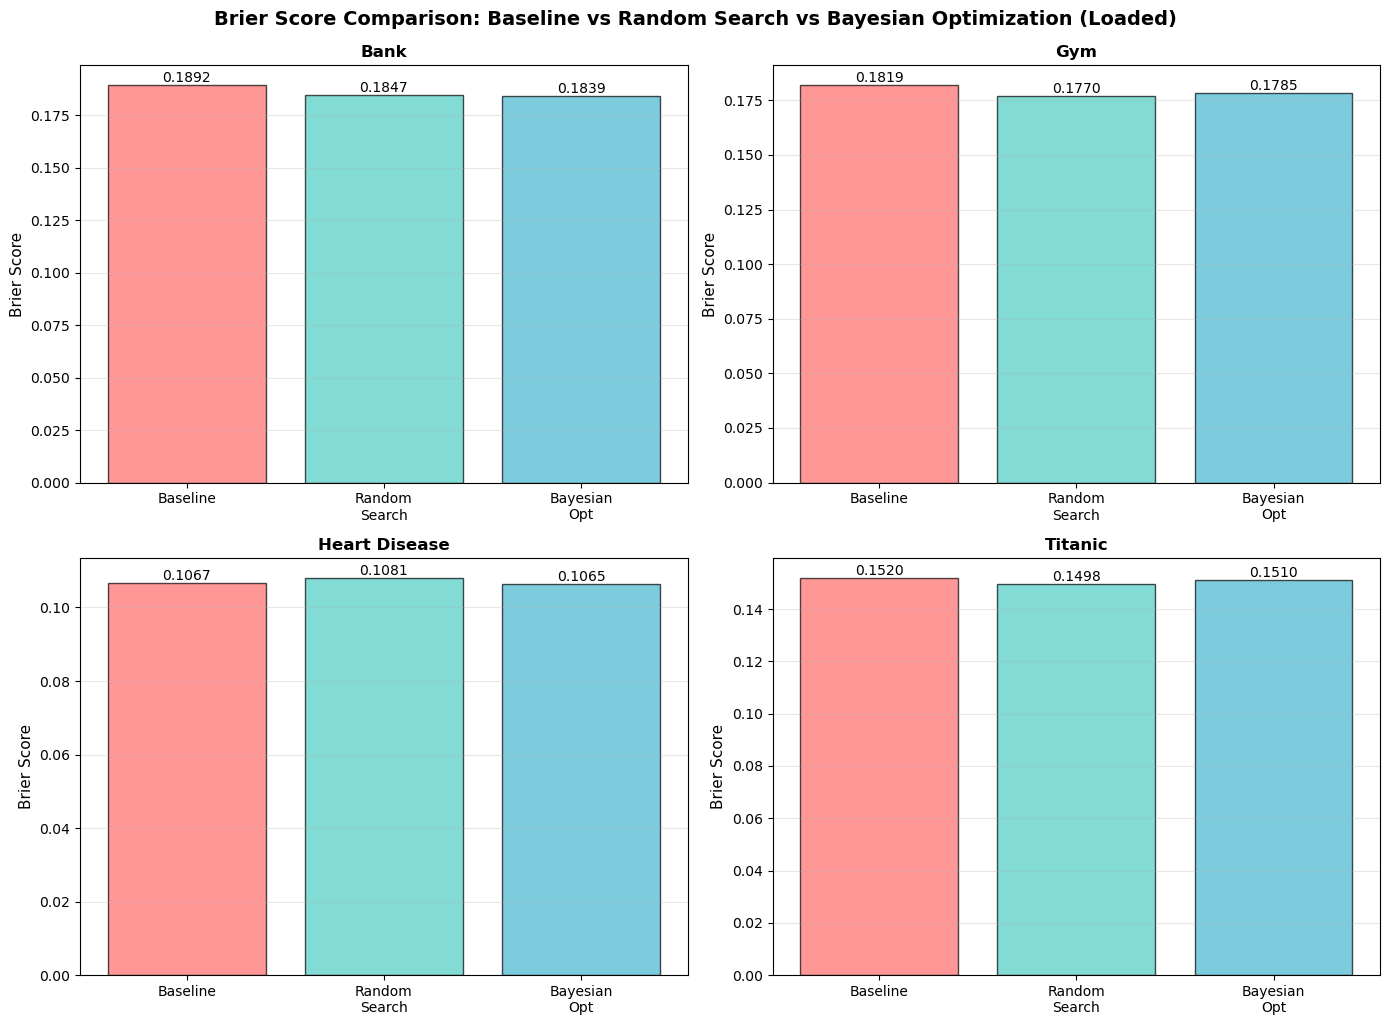

In [20]:
# Visualize comparison using loaded data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (dataset_name, ax) in enumerate(zip(dataset_names, axes)):
    methods = ['Baseline', 'Random\nSearch', 'Bayesian\nOpt']
    scores = [baseline_brier_scores[i], tuned_brier_scores_loaded[i], bayes_brier_scores_loaded[i]]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    
    bars = ax.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Brier Score', fontsize=11)
    ax.set_title(f'{dataset_name}', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle('Brier Score Comparison: Baseline vs Random Search vs Bayesian Optimization (Loaded)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()